# AIPI 590 - XAI | Assignment #6
### Hongxuan Li

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1u7qcFZLb2rRWbY3R3LkNeNXjxpYHyTai?usp=sharing)

#### References

- Model LightGBM: https://github.com/microsoft/LightGBM
- PDP/ICE Plot: https://scikit-learn.org/stable/
- ALE Plot: https://github.com/blent-ai/ALEPython
- Interpretation Tool SHAP: https://github.com/shap/shap
- Dataset California House Prices: https://scikit-learn.org/1.5/modules/generated/sklearn.datasets.fetch_california_housing.html

In [12]:
# import os

# # Remove Colab default sample_data
# !rm -r ./sample_data

# # Clone GitHub files to colab workspace
# repo_name = "/content/AIPI590-XAI" # Change to your repo name
# git_path = 'https://github.com/h0ngxuanli/AIPI590-XAI.git' #Change to your path
# !git clone "{git_path}"


# # Install dependencies from requirements.txt file
# !pip install -r "{os.path.join(repo_name,'assignment6/requirements.txt')}" #Add if using requirements.txt

# # Change working directory to location of notebook
# notebook_dir = 'assignment6/'
# path_to_notebook = os.path.join(repo_name,notebook_dir)
# %cd "{path_to_notebook}"
# %ls


# Dependencies

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from alepython import ale_plot

# Dataset

In [14]:
# load dataset
california = fetch_california_housing()
df = pd.DataFrame(california.data, columns=california.feature_names)
df['target'] = california.target
X, y = california.data, california.target

# split dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
X_train = train_df.drop('target', axis=1)
y_train = train_df['target']
X_test = test_df.drop('target', axis=1)
y_test = test_df['target']


# Load LightGBM

In [15]:
model = lgb.LGBMRegressor(random_state=42, num_leaves=31, learning_rate=0.05, feature_fraction=0.9, n_estimators=100, verbose = -1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")


Mean Squared Error: 0.2343


# PDP Plot: Only consider marginal distributions of features

`MedInc (Median Income)`:
- Explanation: Positive correlation. This suggests that higher income levels in a neighborhood are associated with higher property values

`HouseAge (Median Age of Houses)`:

- Explanation: Positive rcorrelation, especially after around 30 years of age. This may indicate that older neighborhoods might have higher property values.


`AveRooms (Average Rooms per Household)`:

- Explanation: Initially, the price drops slightly but increases as the number of rooms exceeds 5. This indicates that homes with more rooms generally correspond to higher property values, but the effect is less pronounced at the lower end of the room count.


`AveBedrms (Average Bedrooms per Household)`:

- Explanation: Positive correlation. The effect flattens at higher values, indicating a diminishing return in terms of predicted price with additional bedrooms.


`Population`:

- Explanation: Positive correlation.  This suggests that higher population density in a block group might slightly elevate property values.


`AveOccup (Average Occupants per Household)`:

- Explanation: Negative correlation. This could indicate that areas with more crowded living conditions might be associated with lower property values.

`Latitude`:

- Explanation: Negative correlation. This might reflect the concentration of higher property values in more southern regions of California, such as coastal areas.


`Longitude`:

- Explanation: Negative correlation. This suggests that properties closer to the coast (lower longitude) tend to be more expensive, which aligns with the high value of coastal real estate in California.


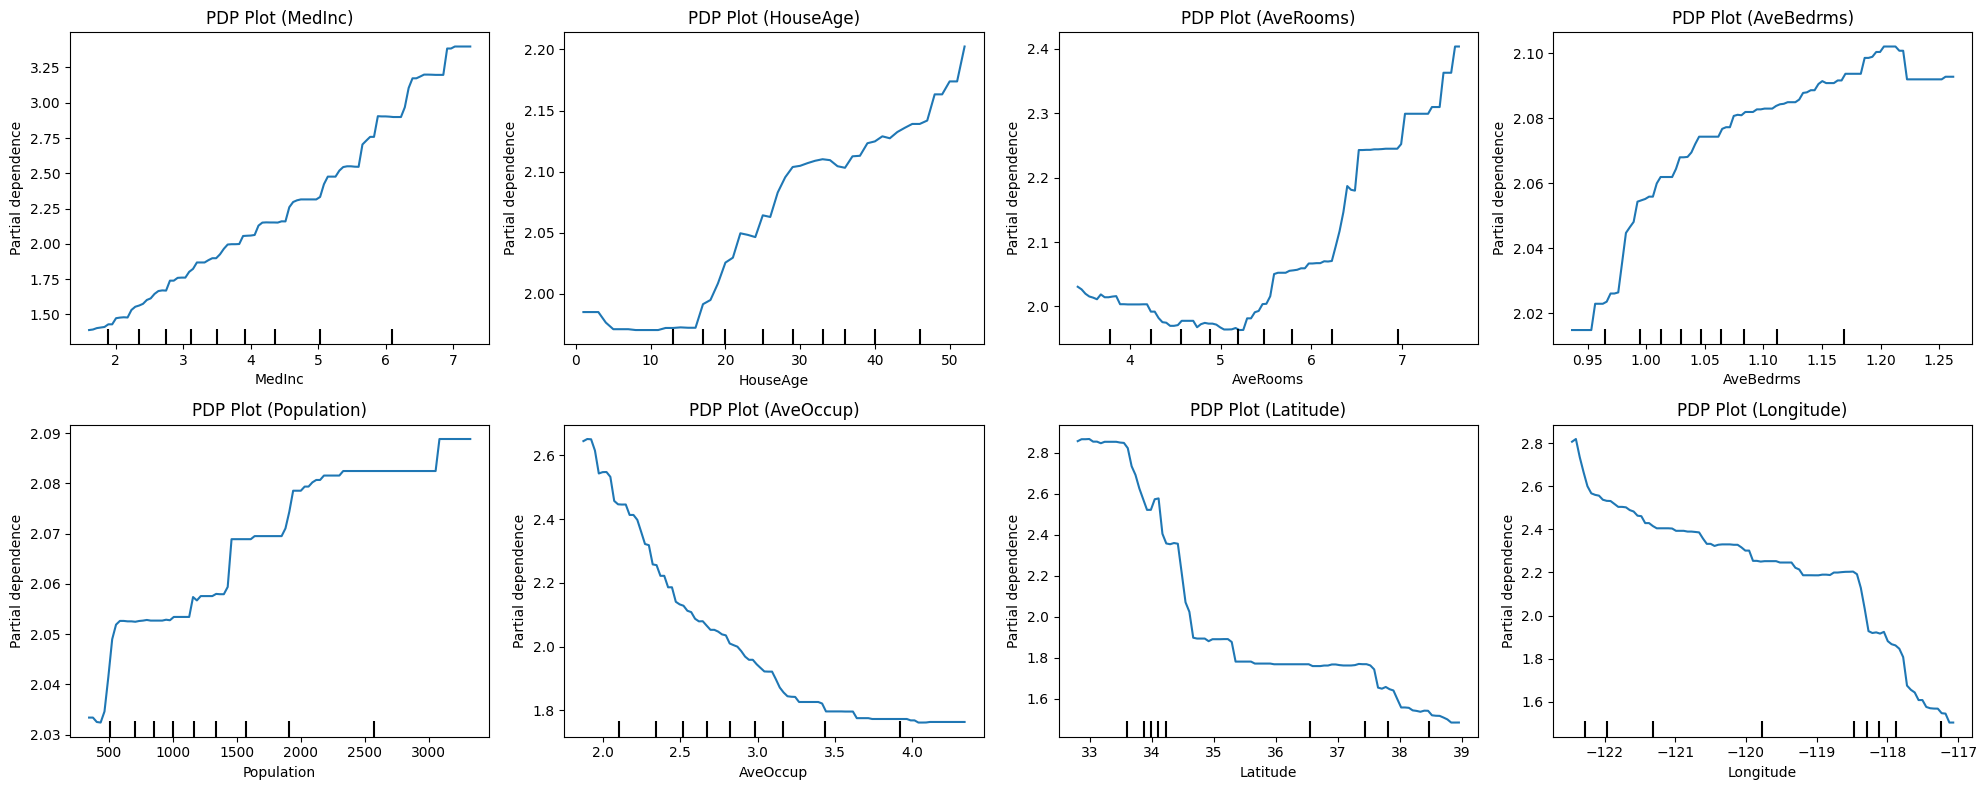

In [16]:
# create subplot for each feature
n_features = X.shape[1]
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8))
axes = axes.ravel()

# plot PDP
for i in range(n_features):
    PartialDependenceDisplay.from_estimator(
        model, X_test, features=[i],
        feature_names=california.feature_names,
        # feature_names=[california.feature_names[i]],
        kind='average', ax=axes[i], random_state=42
    )
    axes[i].set_title(f'PDP Plot ({california.feature_names[i]})')

# hide subplots
for j in range(n_features, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



# ICE Plot

`MedInc (Median Income)`:
- Explanation: Individual samples show consistent pattern, which means median income is an impactful factor that decide the house price.

`HouseAge (Median Age of Houses)`:

- Explanation:  There are a few curves that show a sharp increase in price with older ages, indicating that house age may interact with other features to create this non-linear effect.


`AveRooms (Average Rooms per Household)`:

- Explanation: For some samples, the effect of adding more rooms diminishes at higher room counts.


`AveBedrms (Average Bedrooms per Household)`:

- Explanation: Most curves exhibit similar behavior, indicating that the effect of the number of bedrooms is fairly uniform across different samples.


`Population`:

- Explanation: Most curves remain flat and consistent. This suggests that population size has a limited impact on house prices.


`AveOccup (Average Occupants per Household)`:

- Explanation: The significant drop in some of the curves shows that for a large group of samples, an increase in occupants per household has a stronger negative effect on house prices.

`Latitude`:

- Explanation: Most samples suggests shows a negative relationship between latitude and house prices.



`Longitude`:

- Explanation: The consistency of the decreasing trend across most samples suggests that the relationship between longitude and house prices is fairly global.


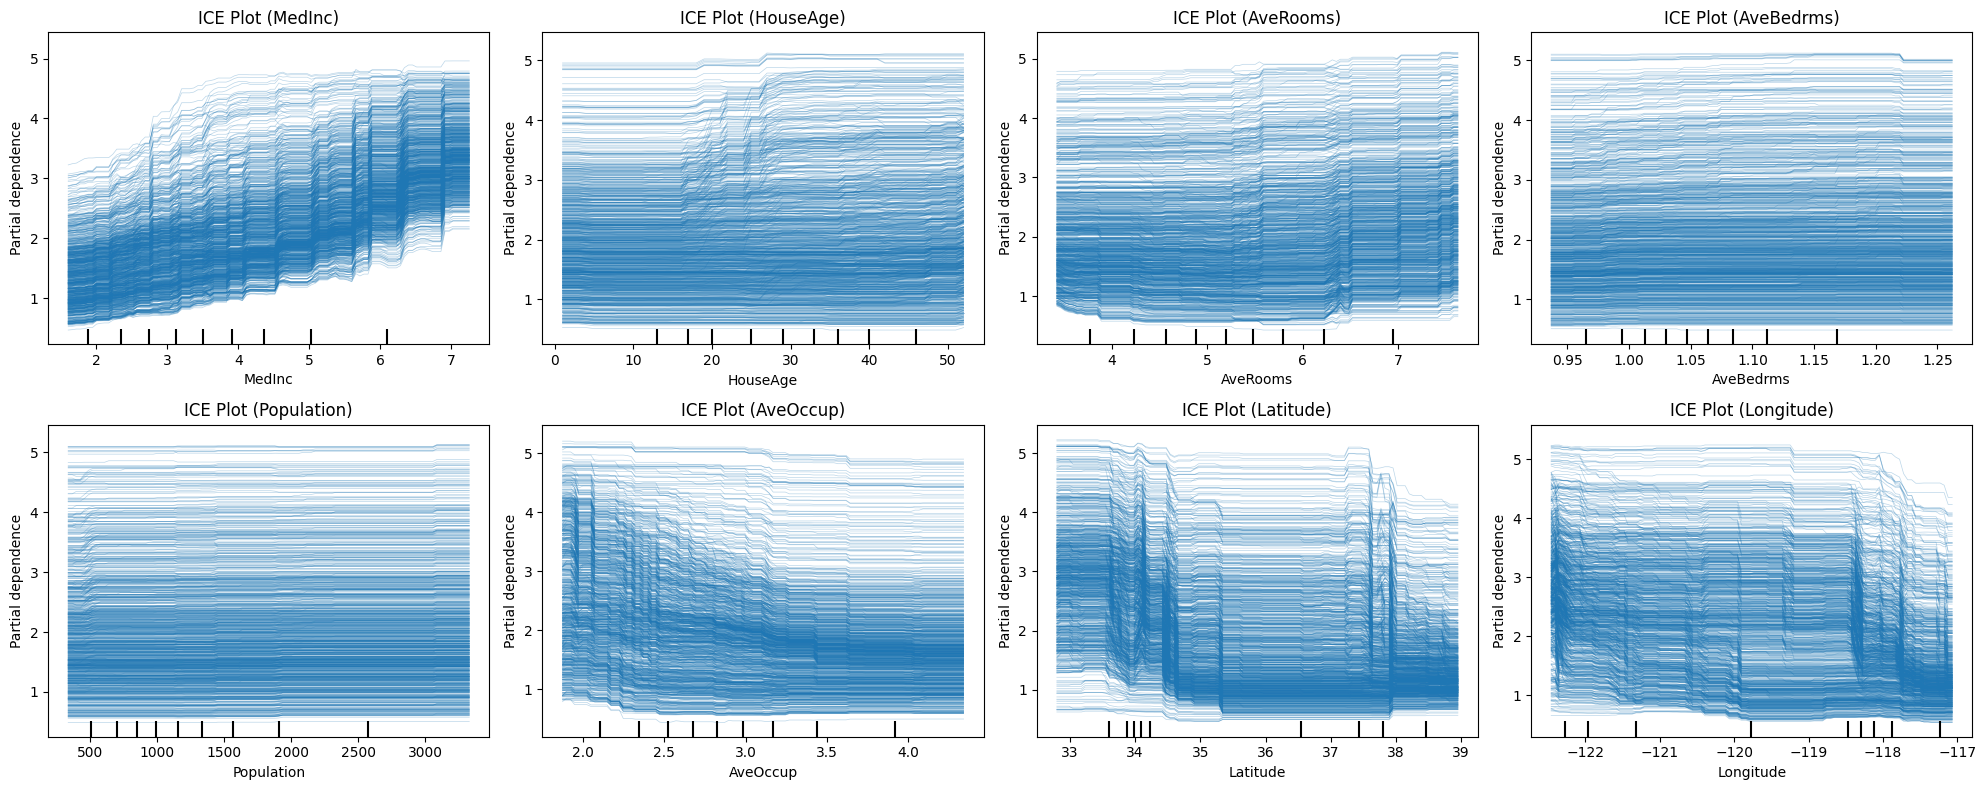

In [17]:
# create subplot for each feature
n_features = X.shape[1]
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8))
axes = axes.ravel()

# plot ICE
for i in range(n_features):
    PartialDependenceDisplay.from_estimator(
        model, X_test, features=[i],
        feature_names=california.feature_names,
        # feature_names=[california.feature_names[i]],
         kind='individual', ax=axes[i], random_state=42, ice_lines_kw={'alpha': 0.3}
    )
    axes[i].set_title(f'ICE Plot ({california.feature_names[i]})')

# hide subplots
for j in range(n_features, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



# ALE Plot: Consider conditional marginal distributions of features

`MedInc (Median Income)`:
- Explanation:  As median income increases, the model predicts higher house prices, indicating that median income is a strong positive factor in determining house prices.

`HouseAge (Median Age of Houses)`:

- Explanation:  As the age of the house increases, the predicted house prices increase. Those older houses in California are may located at prime locations, close to city centers or coastlines, making them valuable.


`AveRooms (Average Rooms per Household)`:

- Explanation: Overall positive relationship. House with fewer rooms (such as small apartments) are generally less expensive, particularly in urban areas with limited space.


`AveBedrms (Average Bedrooms per Household)`:

- Explanation: Overall positive relationship. As the number of bedrooms increases, houses tend to be larger, more spacious, and often located in suburban areas. This could lead to higher property values.


`Population`:

- Explanation: Houses in more populated areas tend to have higher prices. This aligns with California’s urban centers, where more populated regions have higher housing demand.


`AveOccup (Average Occupants per Household)`:

- Explanation: High occupancy per household tends to be associated with lower house prices, likely because higher occupancy can indicate overcrowded housing areas, which are less expensive.

`Latitude`:

- Explanation: Higher latitudes correspond to areas farther north, which tend to be less expensive compared to the southern parts, such as Los Angeles or San Diego.

`Longitude`:

- Explanation: As you move towards the eastern parts, especially around cities like San Francisco and Los Angeles, houses are more expensive.


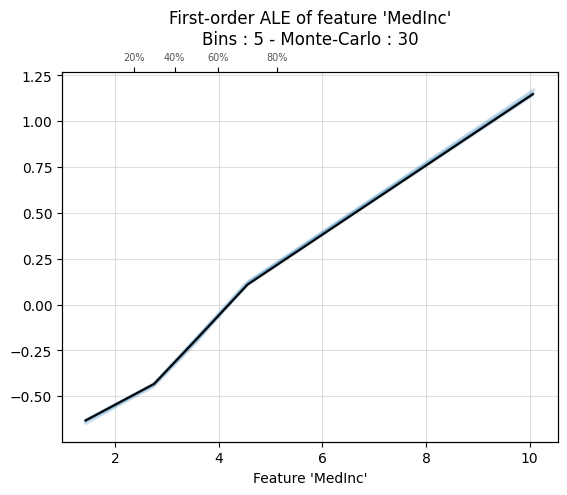

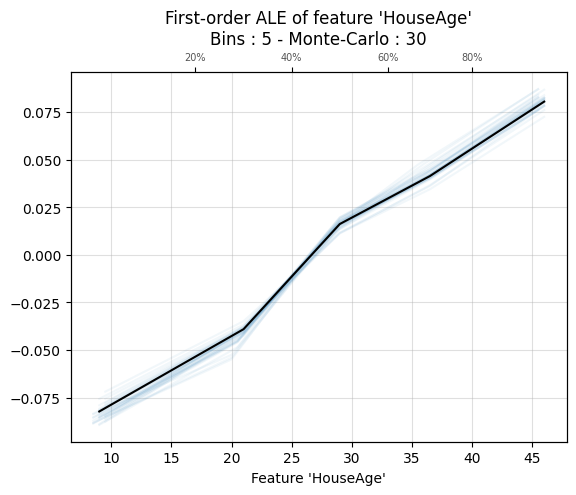

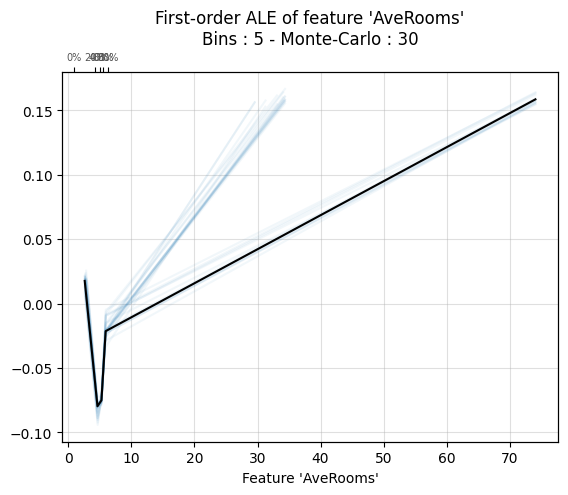

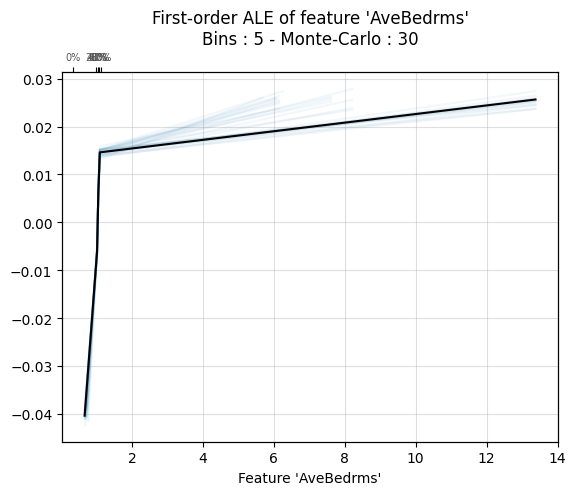

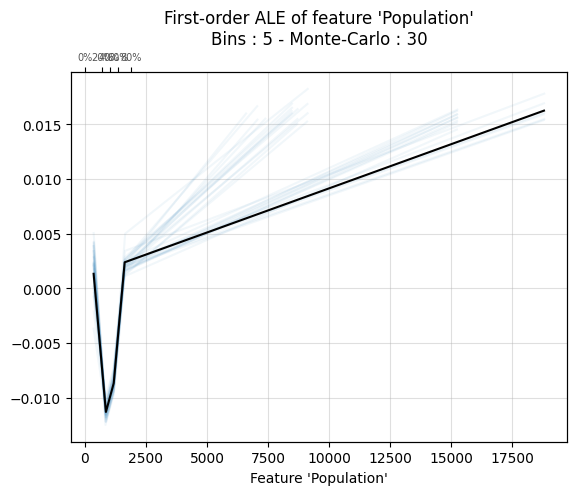

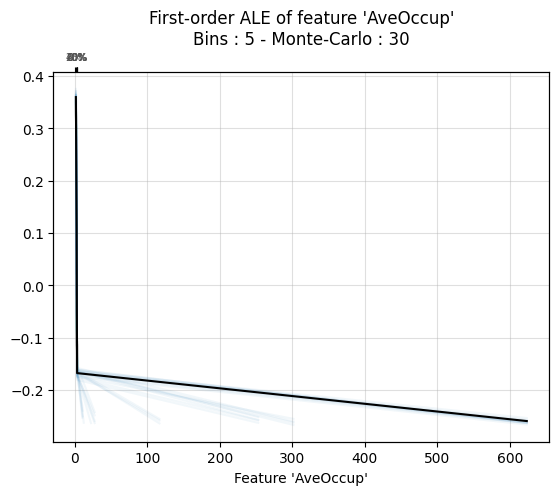

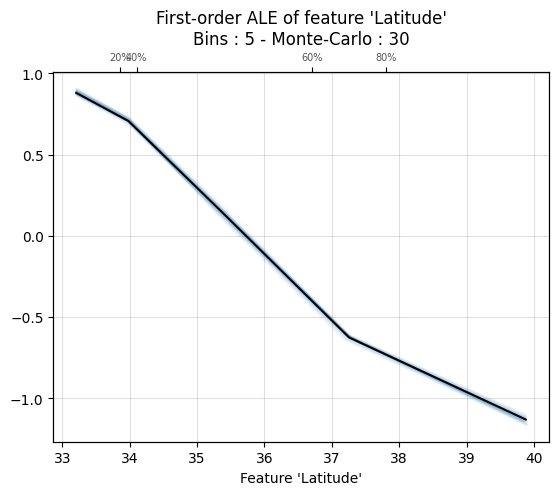

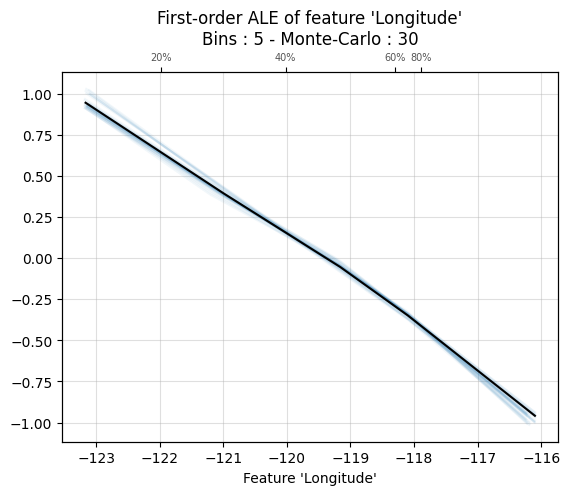

In [19]:

# create subplot for each feature
n_features = X.shape[1]
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols
# plot ICE
for i in range(n_features):
  ale_plot(
      model,
      X_train,
      california.feature_names[i],
      bins=5,
      monte_carlo=True,
      monte_carlo_rep=30,
      monte_carlo_ratio=0.4,
  )


# EDA on Dataset

## Impact on PDP Plot / ICE Plot

**PDP assumption:** PDP/ICE assumes the independency between features. This means that if two features are highly correlated, the PDP/iCE may be misleading as it does not account for the dependencies between these correlated features.

**Explanation:** From example, we can see that the correlation coefficient between AveRooms and AveBedrms is 0.85, indicating a high positive correlation. This means changing AveRooms alone in the PDP/ICE plot may misrepresent its true contribution, ignoring the joint effect with AveBedrms.


## Implact on ALE Plot

**ALE assumption:** Different from PDP and ICE plot, ALE calculates the local partial derivatives of the model output with respect to a feature across different intervals of the data to determine the effects of features instead of assuming complete independence.

**Explanation:**
Unlike PDP or ICE plots, ALE is less sensitive to feature dependency. ALE plots indicate that the features do not have consistent pattern w.r.t. model predicton. Instead, the relationship could change based on value interval, which is a combined effect with other features.

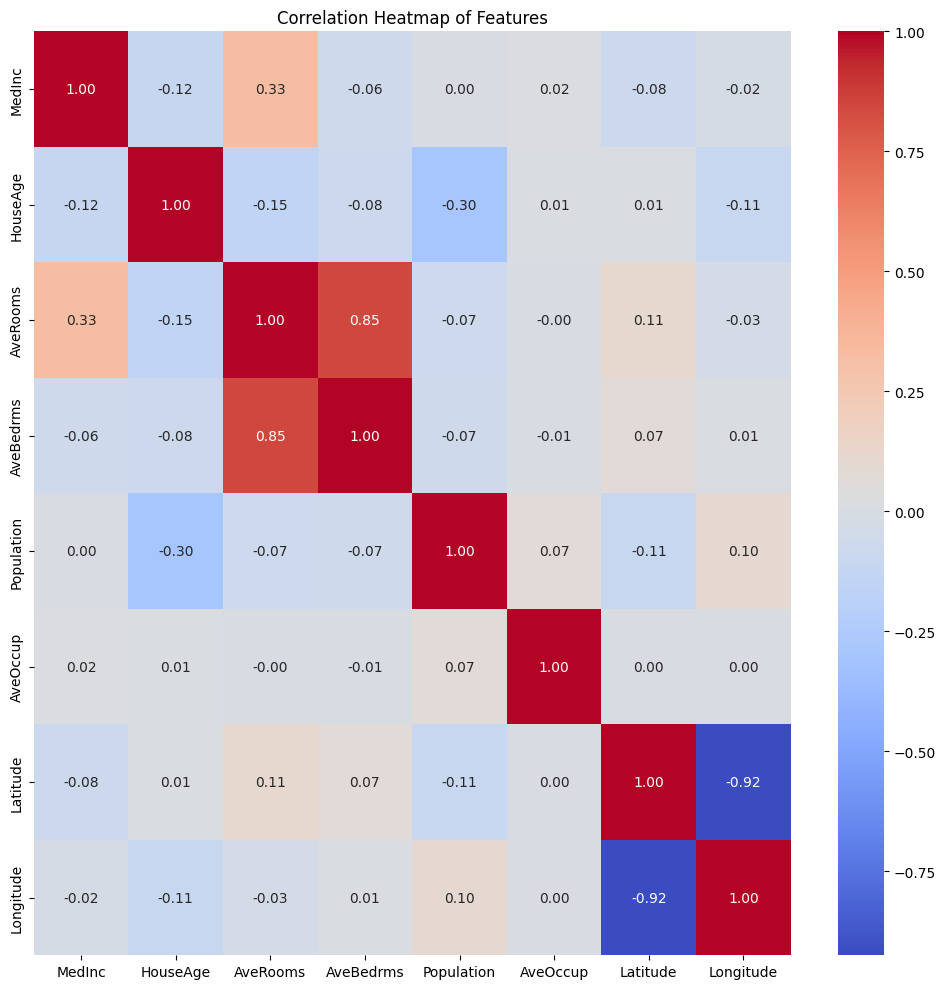


Feature Importance:
      feature  importance
7   Longitude         833
6    Latitude         802
5    AveOccup         351
0      MedInc         343
1    HouseAge         225
2    AveRooms         193
3   AveBedrms         127
4  Population         126


In [20]:
# get correlaton matrix
fig, ax = plt.subplots(figsize=(10, 10))
correlation_matrix = pd.DataFrame(X, columns=california.feature_names).corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt='.2f', ax=ax)
ax.set_title('Correlation Heatmap of Features')
plt.tight_layout()
plt.savefig('lightgbm_analysis.png')
plt.show()


# get feature importance from LightGBM
importance = model.booster_.feature_importance()
feature_importance = pd.DataFrame({'feature': california.feature_names, 'importance': importance})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)